In [195]:
from typing import List
import heapq
import random as rand
import pandas as pd

class Process:
    def __init__(self, id: int, burst_time: int, priority: int, arr_time: int , waiting_time : int = 0, cpu_time_acquired : int  = 0, turnaround_time : int = 0) -> None:
        
        self.id = id
        self.burst_time = burst_time
        self.priority = priority
        self.arrival_time = arr_time

        # waiting time is the time between submission to system and starting execution 

        
        self.waiting_time = 0
        self.cpu_time_acquired = 0
        self.turnaround_time = 0
        

        # this would be relevant for preemptive algorithms
        self.last_running_time = 0
        self.max_waiting_time = 0
        self.age = 0
        


    

    @staticmethod
    def generate_processes(file_name :str, number_of_processes : int ,  max_burst :int , min_burst:int, max_arrival_time:int) -> []:
        file = open(file_name, 'w')
        file.write("id,burst_time,priority,arrival_time,turnaround_time,cpu_time_acquired,waiting_time" + '\n')
        processes = []
        for i in range(number_of_processes):
            
            id = i+1
            priority = rand.randint(-20, 19)
            burst_time = rand.randint(min_burst, max_burst)
            arrival_time = rand.randint(0,max_arrival_time)
            
            process = Process(id, burst_time, priority, arrival_time)
            processes.append(process)
            file.write(str(process) + '\n')

        file.close()
            
        return processes
    
    @staticmethod
    def load_from_csv(file_name : str) -> []:
        processes =  []
        df = pd.read_csv(file_name)
        for _,row in df.iterrows() :
            process = Process(row["id"], row["burst_time"],row["priority"], row["arrival_time"], row["turnaround_time"] , row["cpu_time_acquired"], row["waiting_time"])
            processes.append(process)

        return processes
    

    @staticmethod 
    def save_processes_csv(file_name : str , processes : []) -> None :
        file = open(file_name , 'w')
        file.write("id,burst_time,priority,arrival_time,turnaround_time,cpu_time_acquired,waiting_time" + '\n')
        for process in processes : 
            file.write(str(process) + '\n')
        

    def __lt__(self, other):
        if self.priority != other.priority:
            return self.priority < other.priority
        else:
            return self.id < other.id


    def __str__(self):
        return str(self.id) + ',' + str(self.burst_time) + ',' + str(self.priority) + ',' + str(self.arrival_time) + ',' + str(self.turnaround_time) + ',' + str(self.cpu_time_acquired) +',' + str(self.waiting_time)
    

    def display(self):
        return f"Process {self.id} with burst time {self.burst_time} and priority {self.priority} and arrival time {self.arrival_time} and waiting time {self.waiting_time} and turnaround time {self.turnaround_time}"


In [196]:
from collections import deque
def Priority_round_robin_2(processes : List[Process], quantum : int, context_switching_time : int) -> List[Process]:

    # this time we will write to a csv file which process is being executed and at what time
    file = open("execution.csv", 'w')

    processes.sort(key=lambda x: x.arrival_time)

    # the priority classes range from -20 to 19
    queue_list = [deque() for _ in range(40)]

    current_time = processes[0].arrival_time
    process_index = 0
    finished_processes = 0
    n = len(processes)

    prev = -1


    while process_index < n and processes[process_index].arrival_time == current_time:
        queue_list[processes[process_index].priority + 20].append(processes[process_index])
        process_index += 1        


    while finished_processes < n:

        # dipslay a progression bar here and delete it ater each progress
        # ...
        
        progress = finished_processes / n
        bar_length = 30
        bar = '=' * int(progress * bar_length) + '>' + '-' * (bar_length - int(progress * bar_length))
        print(f"\rProgress: [{bar}] {progress * 100:.2f}%", end='', flush=True)




        found = False 
        for i in range(40):
            if len(queue_list[i]) > 0:
                found = True
                process = queue_list[i].popleft()

                if prev == -1:
                    prev = process.id

                
                if context_switching_time != 0 and prev != process.id:
                        file.write("Context_Switch," + str(current_time) + ',')
                        current_time += context_switching_time
                        file.write(str(current_time) + '\n')



                file.write(str(process.id) + ',' + str(current_time) + ',')



                # print("-----> Operating on process ", process.id, " with priority ", process.priority, " at time ", current_time)

                
                if process.burst_time - process.cpu_time_acquired <= quantum:
                    process.max_waiting_time = max(process.max_waiting_time, process.waiting_time)

                    current_time += process.burst_time - process.cpu_time_acquired
                    process.cpu_time_acquired = process.burst_time
                    process.turnaround_time = current_time - process.arrival_time

                    process.waiting_time = process.turnaround_time - process.burst_time
                    process.last_running_time = current_time

                    finished_processes += 1
                    file.write(str(current_time) + '\n')


                    while process_index < n and processes[process_index].arrival_time <= current_time:
                        # print("Added process ", processes[process_index].id, " to queue ")
                        queue_list[processes[process_index].priority + 20].append(processes[process_index])
                        process_index += 1
                    


                else:
                    process.max_waiting_time = max(process.max_waiting_time, process.waiting_time)

                    current_time += quantum
                    process.cpu_time_acquired += quantum
                    file.write(str(current_time) + '\n')

                    process.last_running_time = current_time


                    while process_index < n and processes[process_index].arrival_time <= current_time:
                        # print("Added process ", processes[process_index].id, " to queue ")
                        queue_list[processes[process_index].priority + 20].append(processes[process_index])
                        process_index += 1
                    queue_list[i].append(process)

                
                prev = process.id
                # print("-----> Finished process ", process.id, " at time ", current_time)
                break

        if not found:
            current_time = processes[process_index].arrival_time
            while process_index < n and processes[process_index].arrival_time == current_time:
                queue_list[processes[process_index].priority + 20].append(processes[process_index])
                process_index += 1

    file.close()

    


    # sort the processes based on their id
    processes.sort(key=lambda x: x.id)
    return processes, current_time


In [197]:
def max(a, b):
    return a if a > b else b

In [198]:
def round_robin_with_aging(processes: List[Process], quantum: int, context_switching_time: int) -> List[Process]:
    # this time we will write to a csv file which process is being executed and at what time
    file = open("execution.csv", 'w')

    processes.sort(key=lambda x: x.arrival_time)

    queue = []

    current_time = processes[0].arrival_time
    process_index = 0
    finished_processes = 0
    n = len(processes)

    prev = -1

    while process_index < n and processes[process_index].arrival_time == current_time:
        heapq.heappush(queue, (processes[process_index].age, processes[process_index]))
        process_index += 1

    while finished_processes < n:

        # dipslay a progression bar here and delete it ater each progress
        # ...

        progress = finished_processes / n
        bar_length = 30
        bar = '=' * int(progress * bar_length) + '>' + '-' * (bar_length - int(progress * bar_length))
        print(f"\rProgress: [{bar}] {progress * 100:.2f}%", end='', flush=True)




        if len(queue) == 0:
            current_time = processes[process_index].arrival_time
            while process_index < n and processes[process_index].arrival_time == current_time:
                heapq.heappush(queue, (processes[process_index].age, processes[process_index]))
                process_index += 1

        age, process = heapq.heappop(queue)
        # print("Operating on process ", process.id, " with age ", process.age, " at time ", current_time)
        if prev == -1:
            prev = process.id

        if context_switching_time != 0 and prev != process.id:
            file.write("Context_Switch," + str(current_time) + ',')
            current_time += context_switching_time
            file.write(str(current_time) + '\n')

        file.write(str(process.id) + ',' + str(current_time) + ',')


        if process.burst_time - process.cpu_time_acquired <= quantum:
            current_time += process.burst_time - process.cpu_time_acquired
            process.cpu_time_acquired = process.burst_time
            process.turnaround_time = current_time - process.arrival_time
            
            
            process.max_waiting_time = max(process.max_waiting_time, current_time - process.last_running_time)
            process.last_running_time = current_time
            
            process.total_waiting_time = process.turnaround_time - process.burst_time
            finished_processes += 1
            file.write(str(current_time) + '\n')

            while process_index < n and processes[process_index].arrival_time <= current_time:
                heapq.heappush(queue, (processes[process_index].age, processes[process_index]))
                process_index += 1

        else:
            current_time += quantum
            process.cpu_time_acquired += quantum
            file.write(str(current_time) + '\n')

            process.max_waiting_time = max(process.max_waiting_time, current_time - process.last_running_time)
            process.last_running_time = current_time

            while process_index < n and processes[process_index].arrival_time <= current_time:
                heapq.heappush(queue, (processes[process_index].age, processes[process_index]))
                process_index += 1
                
            process.age += (process.priority + 21)
            heapq.heappush(queue, (process.age, process))

        prev = process.id

    file.close()

    # compute the waiting time for each process
    for process in processes:
        process.waiting_time = process.turnaround_time - process.burst_time


    # sort the processes based on their id
    processes.sort(key=lambda x: x.id)
    return processes, current_time

# Test 1:

## Generating Random Processes For First Test

In [136]:
# we will generate a list of processes for test purposes>
processes = Process.generate_processes("Aging/starvationTest.csv", 100, 20, 5, 0)

## Testing the Round Robin with Aging

In [199]:
processes = Process.load_from_csv("Aging/starvationTest.csv")
res, time = round_robin_with_aging(processes, 1, 0)

Progress: [>------------------------------] 0.00%

Progress: [=============================>-] 99.00%

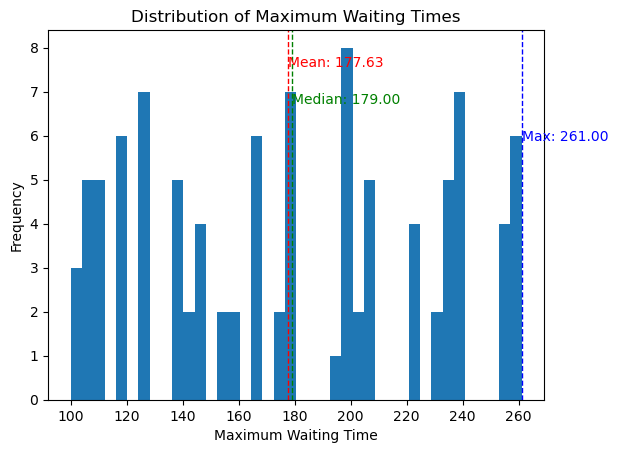

Mean of maximum waiting times is  177.63
Median of maximum waiting times is  179.0
Max of maximum waiting times is  261


In [200]:
# we will plot the distribution of maximum waiting times
import matplotlib.pyplot as plt
import numpy as np

max_waiting_times = [process.max_waiting_time for process in res]
plt.hist(max_waiting_times, bins=40)
plt.xlabel("Maximum Waiting Time")
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Waiting Times")

# we will also show the mean and median of maximum waiting times in form of a vertical line
mean = np.mean(max_waiting_times)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mean, max_ylim*0.9, 'Mean: {:.2f}'.format(mean), color='red')


median = np.median(max_waiting_times)
plt.axvline(median, color='g', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(median, max_ylim*0.8, 'Median: {:.2f}'.format(median), color='green')


mx = np.max(max_waiting_times)
plt.axvline(mx, color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mx, max_ylim*0.7, 'Max: {:.2f}'.format(mx), color='blue')

plt.show()

print("Mean of maximum waiting times is ", mean)
print("Median of maximum waiting times is ", median)
print("Max of maximum waiting times is ", np.max(max_waiting_times))


## Testing the normal round robin algorithm on the test case above.

In [201]:
# load the processes from the csv file
processes = Process.load_from_csv("Aging/starvationTest.csv")

In [202]:
# run the round robin algorithm
res, time = Priority_round_robin_2(processes, 1, 0)

Progress: [=============================>-] 99.00%

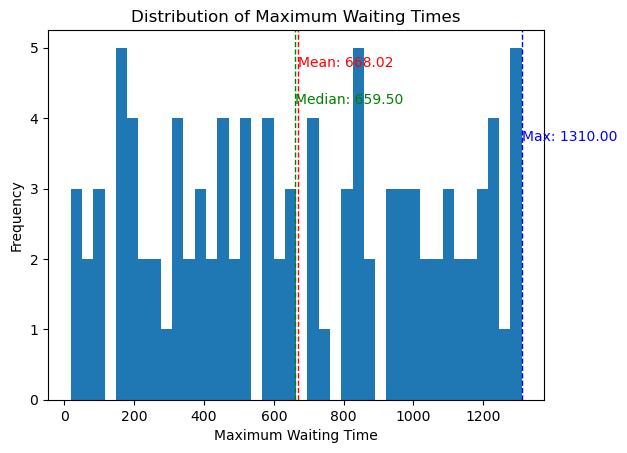

Mean of maximum waiting times is  668.02
Median of maximum waiting times is  659.5
Max of maximum waiting times is  1310


In [203]:
# we will plot the distribution of maximum waiting times
import matplotlib.pyplot as plt
import numpy as np

max_waiting_times = [process.max_waiting_time for process in res]
plt.hist(max_waiting_times, bins=40)
plt.xlabel("Maximum Waiting Time")
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Waiting Times")

# we will also show the mean and median of maximum waiting times in form of a vertical line
mean = np.mean(max_waiting_times)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mean, max_ylim*0.9, 'Mean: {:.2f}'.format(mean), color='red')


median = np.median(max_waiting_times)
plt.axvline(median, color='g', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(median, max_ylim*0.8, 'Median: {:.2f}'.format(median), color='green')


mx = np.max(max_waiting_times)
plt.axvline(mx, color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mx, max_ylim*0.7, 'Max: {:.2f}'.format(mx), color='blue')



plt.show()

print("Mean of maximum waiting times is ", mean)
print("Median of maximum waiting times is ", median)
print("Max of maximum waiting times is ", np.max(max_waiting_times))

## Test 2

In [206]:
# Generating random processes for testing purposes
processes = Process.generate_processes("Aging/starvationTest.csv", 1000, 20, 5, 0)

## Round Robin with aging

In [213]:
# load the processes from the csv file
processes = Process.load_from_csv("Aging/starvationTest.csv")

In [214]:
# run the round robin algorithm
res, time = round_robin_with_aging(processes, 1, 0)

Progress: [=============================>-] 99.90%

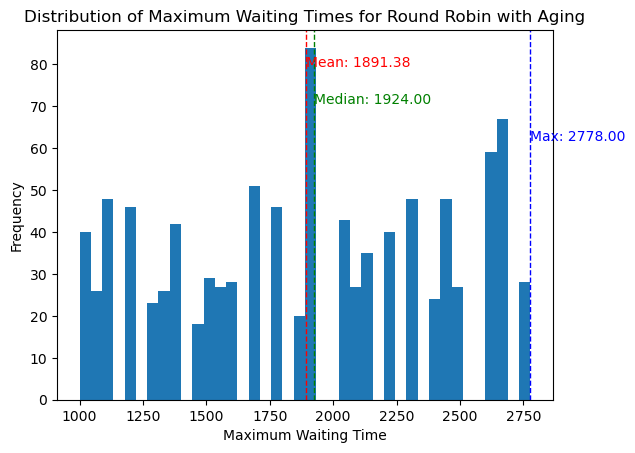

Mean of maximum waiting times is  1891.377
Median of maximum waiting times is  1924.0
Max of maximum waiting times is  2778


In [215]:
# we will plot the distribution of maximum waiting times
import matplotlib.pyplot as plt
import numpy as np

max_waiting_times = [process.max_waiting_time for process in res]
plt.hist(max_waiting_times, bins=40)
plt.xlabel("Maximum Waiting Time")
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Waiting Times for Round Robin with Aging")

# we will also show the mean and median of maximum waiting times in form of a vertical line
mean = np.mean(max_waiting_times)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mean, max_ylim*0.9, 'Mean: {:.2f}'.format(mean), color='red')


median = np.median(max_waiting_times)
plt.axvline(median, color='g', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(median, max_ylim*0.8, 'Median: {:.2f}'.format(median), color='green')


mx = np.max(max_waiting_times)
plt.axvline(mx, color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mx, max_ylim*0.7, 'Max: {:.2f}'.format(mx), color='blue')



plt.show()

print("Mean of maximum waiting times is ", mean)
print("Median of maximum waiting times is ", median)
print("Max of maximum waiting times is ", np.max(max_waiting_times))

## Normal Round Robin

In [216]:
# load the processes from the csv file
processes = Process.load_from_csv("Aging/starvationTest.csv")

In [217]:
# run the round robin algorithm
res, time = Priority_round_robin_2(processes, 1, 0)

Progress: [=============================>-] 99.90%

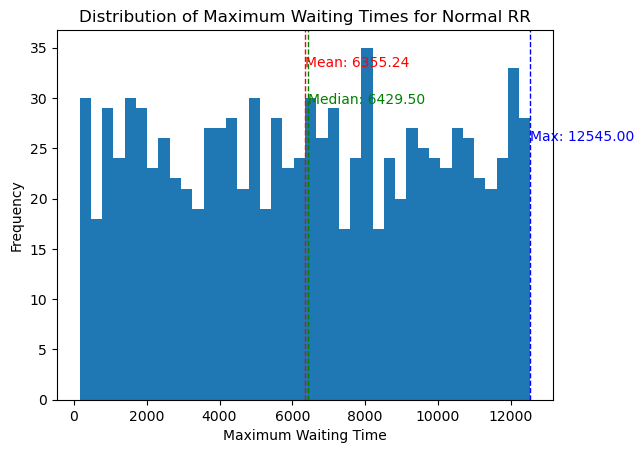

Mean of maximum waiting times is  6355.245
Median of maximum waiting times is  6429.5
Max of maximum waiting times is  12545


In [218]:
# we will plot the distribution of maximum waiting times
import matplotlib.pyplot as plt
import numpy as np

max_waiting_times = [process.max_waiting_time for process in res]
plt.hist(max_waiting_times, bins=40)
plt.xlabel("Maximum Waiting Time")
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Waiting Times for Normal RR")

# we will also show the mean and median of maximum waiting times in form of a vertical line
mean = np.mean(max_waiting_times)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mean, max_ylim*0.9, 'Mean: {:.2f}'.format(mean), color='red')


median = np.median(max_waiting_times)
plt.axvline(median, color='g', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(median, max_ylim*0.8, 'Median: {:.2f}'.format(median), color='green')


mx = np.max(max_waiting_times)
plt.axvline(mx, color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mx, max_ylim*0.7, 'Max: {:.2f}'.format(mx), color='blue')



plt.show()

print("Mean of maximum waiting times is ", mean)
print("Median of maximum waiting times is ", median)
print("Max of maximum waiting times is ", np.max(max_waiting_times))